In [66]:
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from google.cloud import aiplatform

In [3]:
# Initialize the AI Platform client with your project and location
project = "aa-ai-specialisation"
location = "us-central1"
endpoint_id = "9116457725193093120"
endpoint = f"{location}-aiplatform.googleapis.com"
client_options = {"api_endpoint": endpoint}

In [4]:
def endpoint_predict_sample(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    return prediction.predictions

In [18]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client

2024-01-03 03:59:36.642541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 03:59:36.740811: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 03:59:36.743898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-03 03:59:36.743916: I tensorflow/compiler/xla

In [20]:
client = Client()

query = """select 
*
from `aa-ai-specialisation.chicago_taxi_trips.local_taxi_trips`
where trip_start_timestamp >= '2022-01-01' AND
trip_start_timestamp < '2023-01-01'
"""
job = client.query(query)
df = job.to_dataframe()
df = df.drop(columns=["pickup_census_tract", "dropoff_census_tract"])

companies = df["company"].unique()
p_areas = df["pickup_community_area"].unique()
d_areas = df["dropoff_community_area"].unique()


preprocess_bq_query = f"""
CREATE OR REPLACE TABLE chicago_taxi_trips.processed_local_taxi_trips_2022 AS
SELECT 
    fare,
    -- Standardize numeric columns
    (trip_miles - (SELECT AVG(trip_miles) FROM chicago_taxi_trips.local_taxi_trips WHERE trip_start_timestamp >= '2022-01-01' AND trip_start_timestamp < '2023-01-01')) / 
    (SELECT STDDEV(trip_miles) FROM chicago_taxi_trips.local_taxi_trips WHERE trip_start_timestamp >= '2022-01-01' AND trip_start_timestamp < '2023-01-01') AS standardized_trip_miles,
    (trip_seconds - (SELECT AVG(trip_seconds) FROM chicago_taxi_trips.local_taxi_trips WHERE trip_start_timestamp >= '2022-01-01' AND trip_start_timestamp < '2023-01-01')) / 
    (SELECT STDDEV(trip_seconds) FROM chicago_taxi_trips.local_taxi_trips WHERE trip_start_timestamp >= '2022-01-01' AND trip_start_timestamp < '2023-01-01') AS standardized_trip_seconds,
    -- Extract month and hour from timestamp
    EXTRACT(MONTH FROM TIMESTAMP(trip_start_timestamp)) AS trip_start_month,
    EXTRACT(HOUR FROM TIMESTAMP(trip_start_timestamp)) AS trip_start_hour

"""

for c in companies:
    case_statement = f", CASE WHEN company = '{c}' THEN 1 ELSE 0 END AS company_{c}"
    preprocess_bq_query += case_statement

for p in p_areas:
    if type(p) != np.int64:
        continue
    case_statement = f", CASE WHEN pickup_community_area = {p} THEN 1 ELSE 0 END AS pickup_community_area_{p}"
    preprocess_bq_query += case_statement

for d in d_areas:
    if type(d) != np.int64:
        continue
    case_statement = f", CASE WHEN dropoff_community_area = {d} THEN 1 ELSE 0 END AS dropoff_community_area_{d}"
    preprocess_bq_query += case_statement

preprocess_bq_query_2 = f"""
    FROM 
    `aa-ai-specialisation.chicago_taxi_trips.local_taxi_trips`
WHERE
    trip_start_timestamp >= '2022-01-01' AND
    trip_start_timestamp < '2023-01-01' AND
    pickup_community_area IS NOT NULL AND
    dropoff_community_area IS NOT NULL AND
    company IS NOT NULL AND
    trip_miles IS NOT NULL AND
    trip_seconds IS NOT NULL AND
    fare IS NOT NULL
"""

preprocess_bq_query += preprocess_bq_query_2


query_job = client.query(preprocess_bq_query)

In [125]:
client = Client()

query = """select 
*
from `aa-ai-specialisation.chicago_taxi_trips.local_taxi_trips`
where trip_start_timestamp >= '2023-01-01'
"""
job = client.query(query)
df_train = job.to_dataframe()
df_train = df_train.drop(columns=["pickup_census_tract", "dropoff_census_tract"], axis=1)

companies = df_train["company"].unique()
p_areas = df_train["pickup_community_area"].unique()
d_areas = df_train["dropoff_community_area"].unique()

6.04556432998272
1214.9482110779338
7.042050569356675
1626.887239842302


In [32]:
client = Client()
query = """
    SELECT * FROM aa-ai-specialisation.chicago_taxi_trips.processed_local_taxi_trips LIMIT 100
"""
df = client.query(query).to_dataframe()

In [49]:
input_data = np.asarray(df.drop("fare", axis=1)).astype('float32')

In [50]:
import tensorflow as tf

# Path to the directory where the .pb file is stored
model_directory = 'model_20240103-000838'

# Load the model
model = tf.saved_model.load(model_directory)
input_data = input_data

In [51]:
def endpoint_predict_sample(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    return prediction.predictions

In [55]:
instances = [[ -0.8040112 , -0.63467985,  1.        , 16.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]

In [56]:
prediction = endpoint_predict_sample(project, location, instances, endpoint_id)

In [57]:
prediction

[[7.38343048], [7.38343048]]

In [97]:
client = Client()
query = """
    SELECT * FROM aa-ai-specialisation.chicago_taxi_trips.processed_local_taxi_trips
"""
df = client.query(query).to_dataframe()

In [98]:
labels = df['fare'].values
    
features = df.drop('fare', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=features['trip_start_hour'])

In [99]:
X_test = np.asarray(X_test).astype(np.float32)

In [100]:
predictions = model(X_test)

In [101]:
pred = np.array(predictions)

In [102]:
y_test

array([ 6.75, 12.58, 27.  , ..., 26.5 , 16.25, 45.75])

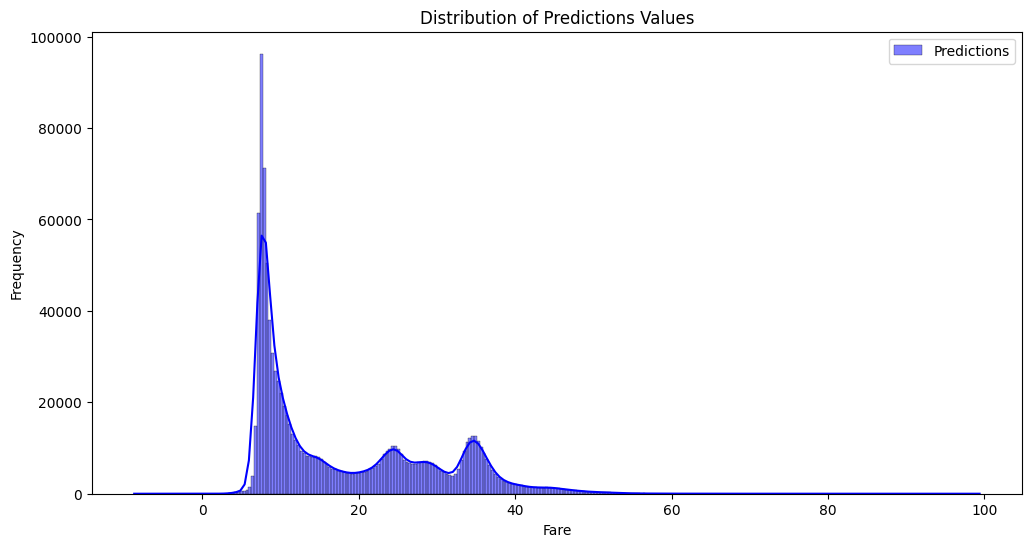

In [103]:
filter_pred = pred[pred < 100]
plt.figure(figsize=(12, 6))
sns.histplot(filter_pred, color='blue', label='Predictions', kde=True)
plt.title('Distribution of Predictions Values')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.legend()
plt.show()

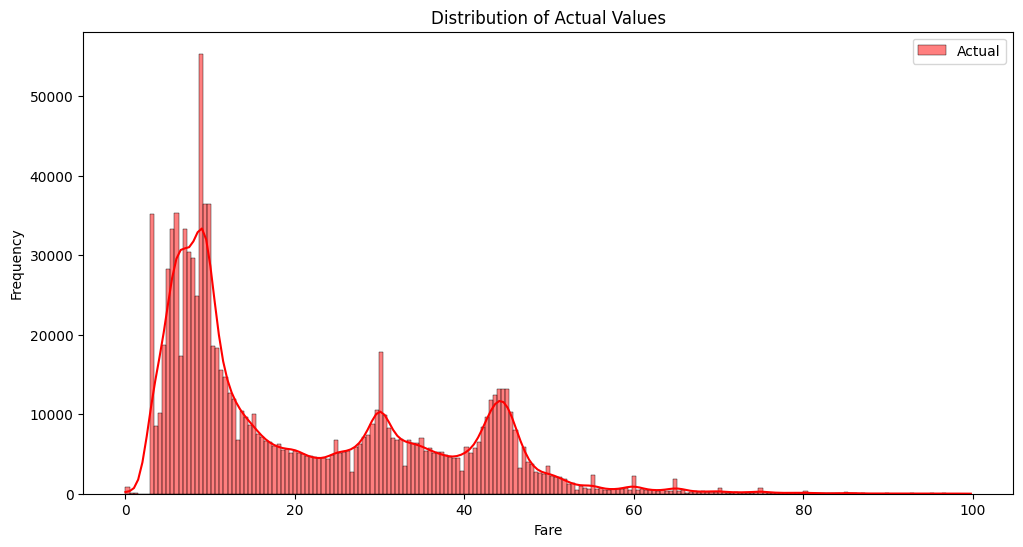

In [104]:
filter_ytest = y_test[y_test < 100]
plt.figure(figsize=(12, 6))
sns.histplot(filter_ytest, color='red', label='Actual', kde=True)
plt.title('Distribution of Actual Values')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [119]:
times = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]
preds = []
for time in times:
    instances = [[ -0.7040112 , -0.58467985,  1.        , time        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]
    
    preds.append(model(instances))

In [120]:
preds = np.array(preds)

In [121]:
preds = list(preds.flatten())

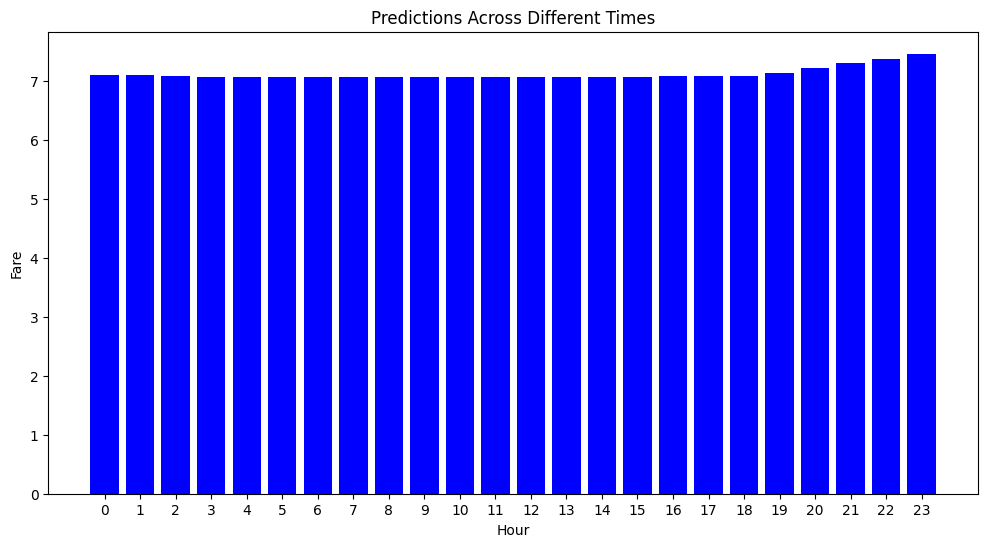

In [126]:
plt.figure(figsize=(12, 6))
plt.bar(times, preds, color='blue')
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.title('Predictions Across Different Times')
plt.xticks(times)
plt.show()

In [127]:
months = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.]
preds = []
for month in months:
    instances = [[ -0.7040112 , -0.58467985,  month        , 9.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]
    
    preds.append(model(instances))

In [128]:
preds = list(np.array(preds).flatten())

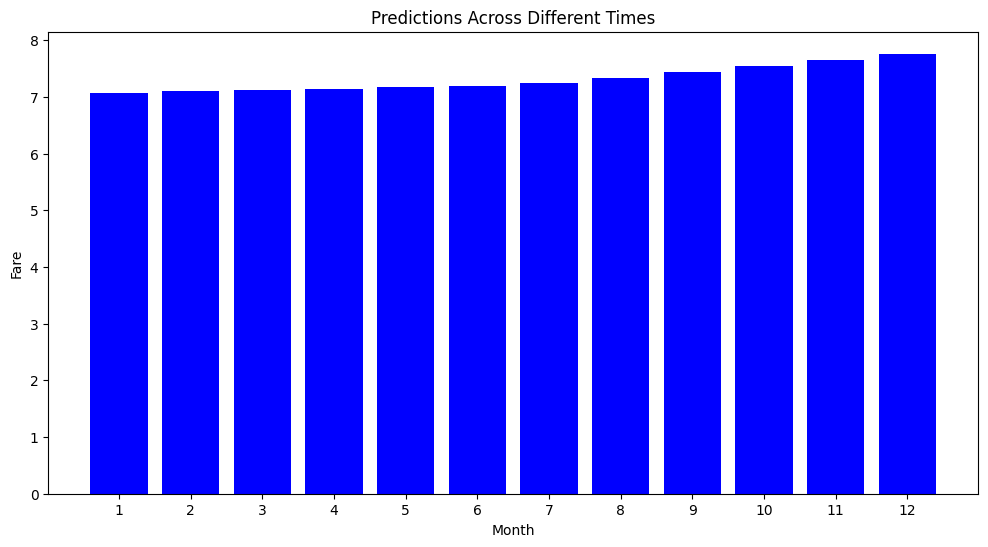

In [130]:
plt.figure(figsize=(12, 6))
plt.bar(months, preds, color='blue')
plt.xlabel('Month')
plt.ylabel('Fare')
plt.title('Predictions Across Different Times')
plt.xticks(months)
plt.show()

In [143]:
company_preds = []
instance_1 = [ -0.7040112 , -0.58467985, 1. , 9.]
instance_2 = []
instance_3 = [0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.]
instance_4 = [0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.]
for i in range(len(companies)):
    count = i
    while count > 0:
        instance_2.append(0)
        count -= 1
    instance_2.append(1)
    count = i
    while len(companies) - count - 1 > 0:
        instance_2.append(0)
        count += 1
    instances = [instance_1+instance_2+instance_3+instance_4]
    company_preds.append(model(instances))
    instance_2 = []
    

In [144]:
company_preds = list(np.array(company_preds).flatten())

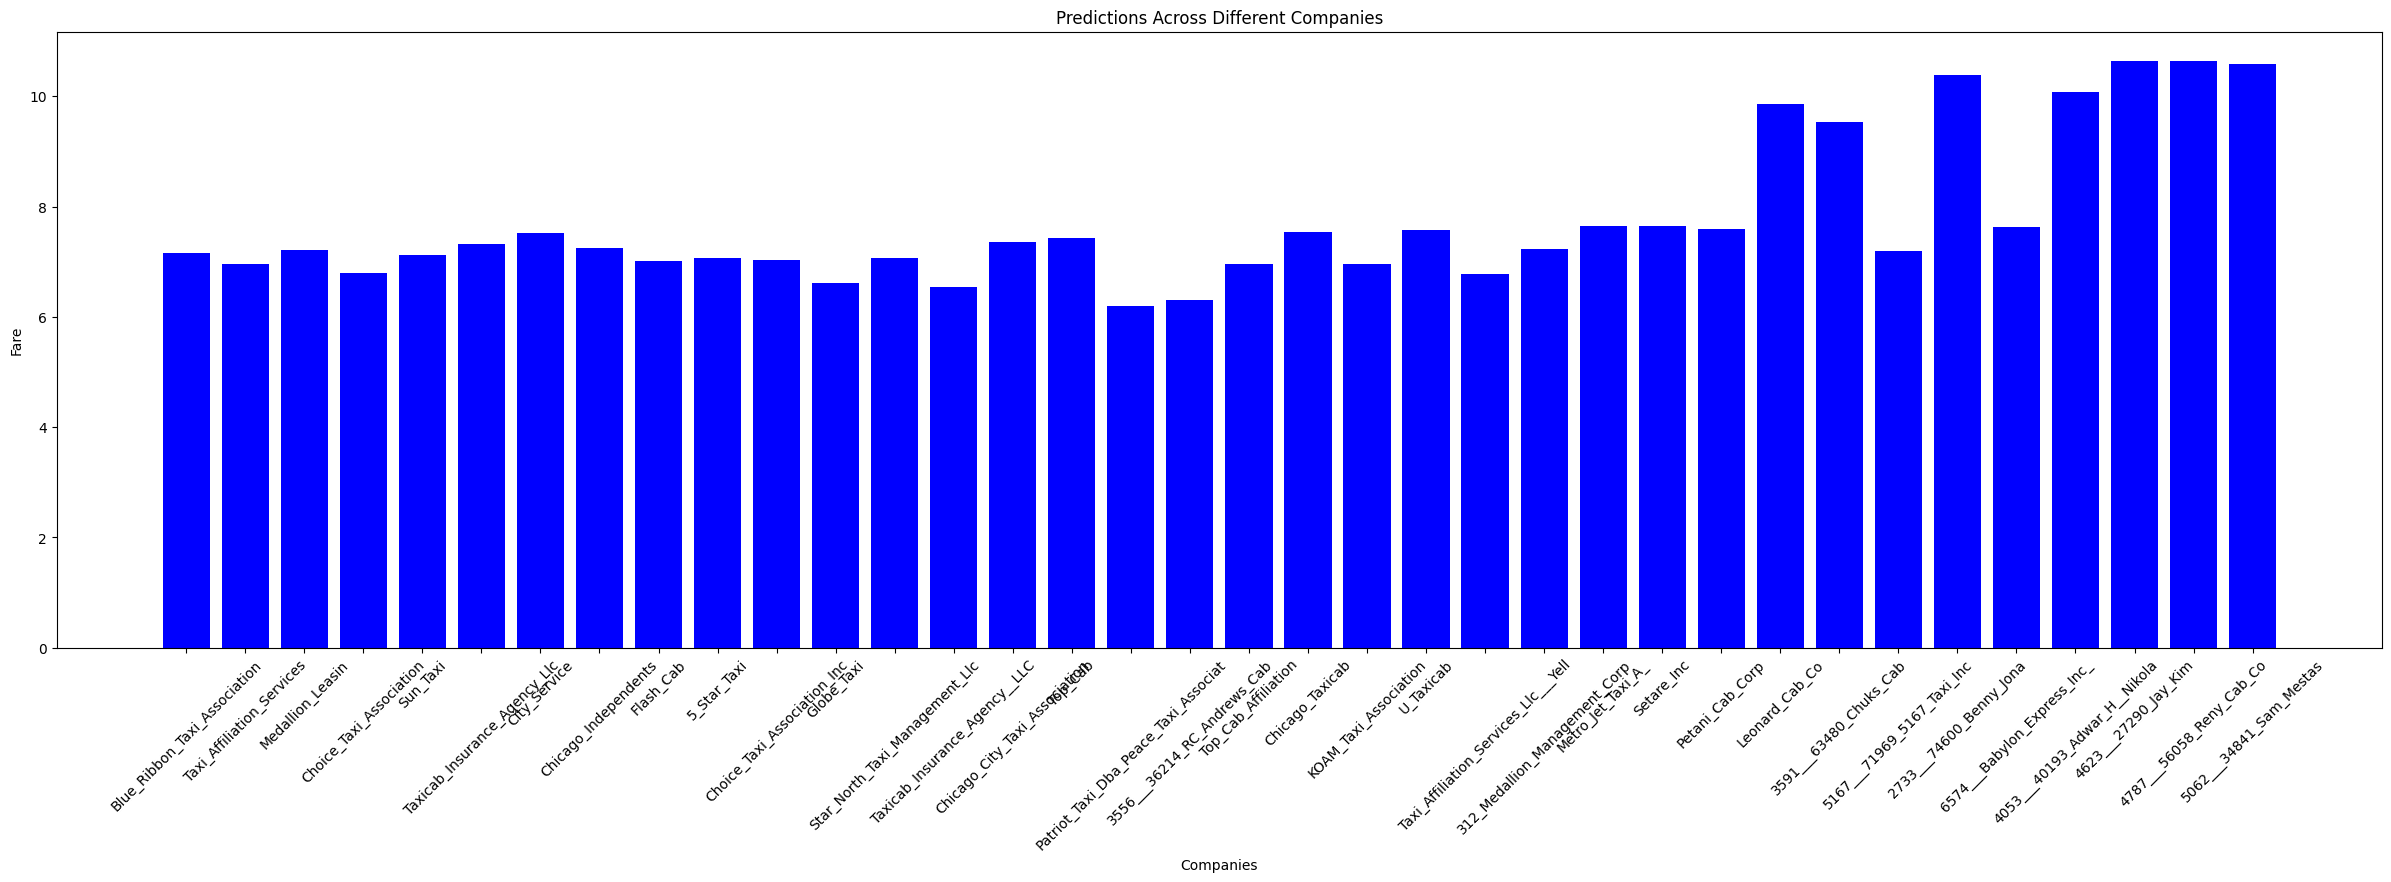

In [148]:
plt.figure(figsize=(30, 8))
plt.bar(companies, company_preds, color='blue')
plt.xlabel('Companies')
plt.ylabel('Fare')
plt.title('Predictions Across Different Companies')
plt.xticks(companies, rotation=45)
plt.show()